In [1]:
import numpy as np
import matplotlib.pyplot as plt

from triqs.gf import *
from itertools import product

In [26]:
def G0(mesh, t, eps, mu):
    g = Gf(mesh = mesh, target_shape = (2, 2))
    for w in mesh:
        g[w] = 0.5 * np.array([
            [1 / (w - eps + mu - t) + 1 / (w - eps + mu + t), 1 / (w - eps + mu - t) - 1 / (w - eps + mu + t)],
            [1 / (w - eps + mu - t) - 1 / (w - eps + mu + t), 1 / (w - eps + mu - t) + 1 / (w - eps + mu + t)],
        ])
    return g



orbitals = 2
t = 1.0
eps = 0.0
mu = 0.0
beta = 100

tij = np.zeros([orbitals] * 2)
for i in range(orbitals - 1):
    tij[i, i + 1] = t
    tij[i + 1, i] = t

H = tij + eps * np.eye(orbitals)

f_mesh = MeshImFreq(beta, 'Fermion',  1 * 1024)
b_mesh = MeshImFreq(beta, 'Fermion',  1 * 1024)
g_inv = Gf(mesh = f_mesh, target_shape = np.shape(H))
g_inv << iOmega_n + mu - H
g_w = g_inv.inverse()
g_w_exact = G0(f_mesh, t, eps, mu)

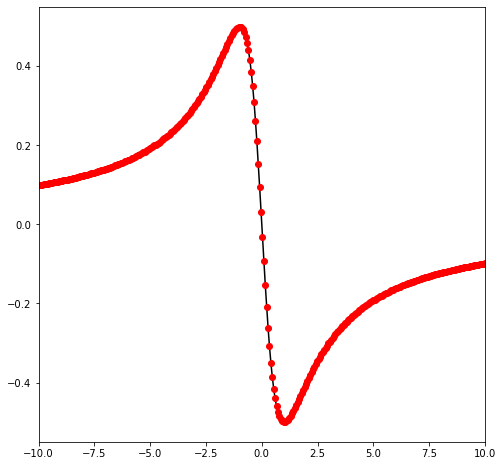

In [27]:
plt.figure(figsize=(8, 8))
plt.xlim(-10, 10)
plt.plot([w.imag for w in g_w.mesh.values()], g_w_exact.data[:, 0, 0].imag, color = 'black', zorder = 0)
plt.scatter([w.imag for w in g_w.mesh.values()], g_w.data[:, 0, 0].imag, color = 'red', zorder = 1)
plt.show()

In [28]:
def selfEnergy(g_w, W_w) :
    g_t = make_gf_from_fourier(g_w)
    W_t = make_gf_from_fourier(W_w)

    sigma_t = g_t.copy()
    sigma_t.data[:] = -W_t.data[:] * g_t.data[:]
    return make_gf_from_fourier(sigma_t)


def I_exact(mesh, V, g, w_ph):
    I0 = Gf(mesh = mesh, target_shape = [])
    I1 = Gf(mesh = mesh, target_shape = [])
    for w in mesh:
        I0[w] = V[0, 0] + 2 * g[0, 0] ** 2 * w_ph / (complex(w) ** 2 - w_ph ** 2)
        I1[w] = V[0, 1] + 2 * g[0, 1] ** 2 * w_ph / (complex(w) ** 2 - w_ph ** 2)
    G = Gf(mesh = mesh, target_shape = np.shape(V))
    G.data[:, 0, 0] = I0.data[:]
    G.data[:, 0, 1] = I1.data[:]
    G.data[:, 1, 0] = I1.data[:]
    G.data[:, 1, 1] = I0.data[:]
    return G


def n_F(e, beta, mu):
    return 1 / (np.exp(beta * (e - mu)) + 1)

def n_B(e, beta, mu):
    return 1 / (np.exp(beta * (e - mu)) - 1)

def sigma_stat(mesh, V, eps, mu, t, beta):
    gf = Gf(mesh = mesh, target_shape = np.shape(V))
    for w in mesh:
        gf[w] = -0.5 * np.array([
            [V[0, 0] * (n_F(eps + t, beta, mu) + n_F(eps - t, beta, mu)), V[0, 1] * (n_F(eps + t, beta, mu) - n_F(eps - t, beta, mu))],
            [V[1, 0] * (n_F(eps + t, beta, mu) - n_F(eps - t, beta, mu)), V[1, 1] * (n_F(eps + t, beta, mu) + n_F(eps - t, beta, mu))]
        ])
    return gf

def sigma_dyn(mesh, g, V, eps, mu, t, beta, w_ph):
    def entry(g, V, eps, mu, t, beta, w_ph, a, b):
        return 0.5 * g[a, b] ** 2 * ((n_B(w_ph, beta, mu) + n_F(eps + t, beta, mu)) / (w + w_ph - eps + mu - t) + 
                                      (n_B(w_ph, beta, mu) + 1 + n_F(eps + t, beta, mu)) / (w - w_ph - eps + mu - t)
                                    + (-1) ** (a-b) * (n_B(w_ph, beta, mu) + n_F(eps - t, beta, mu)) / (w + w_ph - eps + mu + t)
                                    + (-1) ** (a-b) * (n_B(w_ph, beta, mu) + 1 + n_F(eps - t, beta, mu)) / (w - w_ph - eps + mu + t))

    gf = Gf(mesh = mesh, target_shape = np.shape(V))
    for w in mesh:
        gf[w] = -0.5 * np.array([
            [entry(g, V, eps, mu, t, beta, w_ph, 0, 0), entry(g, V, eps, mu, t, beta, w_ph, 0, 1)],
            [entry(g, V, eps, mu, t, beta, w_ph, 1, 0), entry(g, V, eps, mu, t, beta, w_ph, 1, 1)]
        ])
    return gf

w_ph = 1.5


V = np.eye(2) * 0.0
g = np.eye(2) * 0.5



I = I_exact(b_mesh, V, g, w_ph)

sigma_exact = sigma_stat(f_mesh, V, eps, mu, t, beta) + sigma_dyn(f_mesh, g, V, eps, mu, t, beta, w_ph)

sigma = selfEnergy(g_w, I)

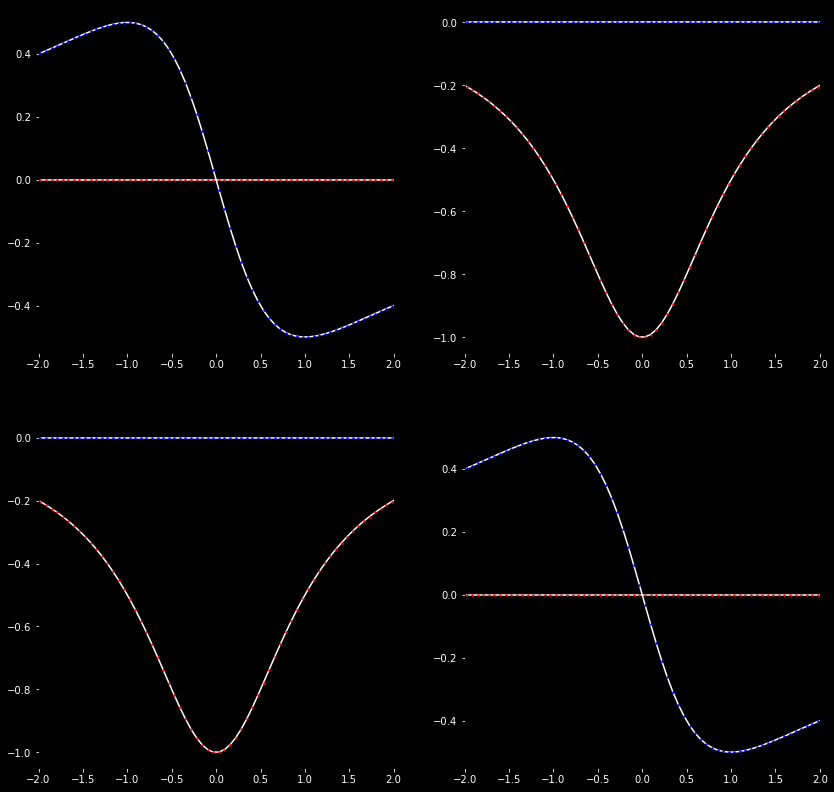

In [30]:
fig, axs = plt.subplots(orbitals, orbitals, figsize = (7 * orbitals, 7 * orbitals), facecolor = 'black')
s = 2
a = g_w
b = g_w_exact
for i in range(orbitals):
    for j in range(orbitals):
        axs[i, j].set_facecolor('black')
        axs[i, j].xaxis.label.set_color('white')
        axs[i, j].tick_params(axis = 'x', colors = 'white')
        axs[i, j].yaxis.label.set_color('white')
        axs[i, j].tick_params(axis = 'y', colors = 'white')
        axs[i, j].set_xlim(-2, 2)

        axs[i, j].plot([w.imag for w in a.mesh.values()], a.data[:, i, j].real, color = 'white', zorder = 0)
        axs[i, j].plot([w.imag for w in a.mesh.values()], a.data[:, i, j].imag, color = 'white', zorder = 0)

        axs[i, j].scatter([w.imag for w in b.mesh.values()], b.data[:, i, j].real, color = 'red', s = s, zorder = 1)
        axs[i, j].scatter([w.imag for w in b.mesh.values()], b.data[:, i, j].imag, color = 'blue', s = s, zorder = 1)